In [2]:
drive.flush_and_unmount()
!rm -rf /content/drive



NameError: name 'drive' is not defined

In [3]:
!ls

drive  sample_data


In [1]:
!pip install -q bert-score pandas openpyxl
!pip install -q pycocoevalcap  # For SPICE
!pip install -U -q google-generativeai

from google.colab import drive
# drive.mount('/content/drive')
drive.mount('/content/drive', force_remount=True)


import pandas as pd
import os
from typing import List, Dict, Optional, Callable
from datetime import datetime

import google.generativeai as genai
import time
import re
from typing import List, Tuple, Optional
from tqdm import tqdm


Mounted at /content/drive


In [ ]:
!find "/content/drive/MyDrive" -maxdepth 5 -type f -name "*.xlsx"


In [ ]:
!ls /content/drive/MyDrive/CameraBench

outputs


In [ ]:
!ls

drive  sample_data


In [3]:
import os

path = "/content/drive/MyDrive/DL_Final/Datasets/Gemini-2.5-Pro/scene_captions_gemini.xlsx"
print("Exists?", os.path.exists(path))
print("Is file?", os.path.isfile(path))
print("Is dir?", os.path.isdir(path))

# Also list the directory
!ls -l "/content/drive/MyDrive/DL_Final/Datasets/Gemini-2.5-Pro/"


Exists? True
Is file? True
Is dir? False
total 807
-rw------- 1 root root 307629 Nov 26 04:58 motion_captions_gemini.xlsx
-rw------- 1 root root 518031 Nov 27 17:03 scene_captions_gemini.xlsx


In [ ]:
!mv "/content/drive/MyDrive/DL_Final/Datasets/Gemini-2.5-Pro/scene_captions_gemini (1).xlsx" "/content/drive/MyDrive/DL_Final/Datasets/Gemini-2.5-Pro/scene_captions_gemini.xlsx"


mv: cannot stat '/content/drive/MyDrive/DL_Final/Datasets/Gemini-2.5-Pro/scene_captions_gemini (1).xlsx': No such file or directory


In [3]:
### Copy over ground truth dataset

import shutil
import os

# === CONFIGURE THIS ===
source_path = "/content/drive/MyDrive/DL_Final/Datasets/Gemini-2.5-Pro/scene_captions_gemini.xlsx"  # wherever your file currently is
target_dir = "/content/drive/MyDrive/CameraBench/inputs"

# Make sure target directory exists
os.makedirs(target_dir, exist_ok=True)

# Compute final destination path (same filename)
target_path = os.path.join(target_dir, os.path.basename(source_path))

# Copy the file (preserves metadata)
shutil.copy2(source_path, target_path)

print(f"Copied:\n  {source_path}\n→ {target_path}")


Copied:
  /content/drive/MyDrive/DL_Final/Datasets/Gemini-2.5-Pro/scene_captions_gemini.xlsx
→ /content/drive/MyDrive/CameraBench/inputs/scene_captions_gemini.xlsx


In [ ]:
# Configuration
EVAL_CONFIG = {
    # "input_path": "/content/drive/MyDrive/qwen25_captions.xlsx",
    # "input_path": "/content/drive/MyDrive/CameraBench/data/qwen25_captions_10samples_20251127_081546.xlsx",
    # "input_path": "drive/MyDrive/CameraBench/outputs/qwen25_ft_captions_200samples_20251128_051937.xlsx",
    # "input_path": "drive/MyDrive/CameraBench/outputs/qwen25_ft_captions_200samples_20251128_072632.xlsx",
    "input_path": "drive/MyDrive/CameraBench/outputs/qwen25_redone_captions_200samples_20251130_220922.xlsx",
    # qwen25_ft_captions_200samples_20251128_072632
    "output_dir": "drive/MyDrive/CameraBench/outputs",
    "bert_batch_size": 32,
    "lang": "en",
}

os.makedirs(EVAL_CONFIG["output_dir"], exist_ok=True)
print("✓ Setup complete")

# Configure Gemini
GEMINI_API_KEY = "INSERT YOUR API KEY here"
genai.configure(api_key=GEMINI_API_KEY)

# Initialize model
gemini_model = genai.GenerativeModel("gemini-2.5-pro-preview-05-06")

print("✓ Gemini 2.5 Pro configured")

✓ Setup complete
✓ Gemini 2.5 Pro configured


# Metric Functions

In [5]:
from bert_score import score as bert_score_fn

def metric_bertscore(candidates: List[str], references: List[str], **kwargs) -> List[float]:
    """
    Compute BERTScore F1 between candidates and references.
    """
    batch_size = kwargs.get("batch_size", 32)
    lang = kwargs.get("lang", "en")

    P, R, F1 = bert_score_fn(
        candidates,
        references,
        lang=lang,
        batch_size=batch_size,
        verbose=True
    )
    return F1.tolist()


# def metric_spice(candidates: List[str], references: List[str], **kwargs) -> List[float]:
#     """
#     Compute SPICE score between candidates and references.
#     """
#     from pycocoevalcap.spice.spice import Spice

#     # Format for pycocoevalcap: {id: [caption]}
#     gts = {i: [ref] for i, ref in enumerate(references)}
#     res = {i: [cand] for i, cand in enumerate(candidates)}

#     spice = Spice()
#     avg_score, all_scores = spice.compute_score(gts, res)

#     scores = [s["All"]["f"] for s in all_scores]
#     return scores


def metric_spice(candidates: List[str], references: List[str], **kwargs) -> List[float]:
    """
    Compute SPICE score using a correct COCO-style JSON format.
    This bypasses the broken SPICE JSON writer in pycocoevalcap.
    """
    import json, tempfile, os
    from pycocoevalcap.spice.spice import Spice

    # Build COCO-format JSON: annotations, images, res
    data = {
        "annotations": [],
        "images": [],
        "res": []
    }

    for i, ref in enumerate(references):
        data["images"].append({"id": i})
        data["annotations"].append({"image_id": i, "caption": ref})

    for i, cand in enumerate(candidates):
        data["res"].append({"image_id": i, "caption": cand})

    # Write temp JSON file
    tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".json")
    with open(tmp.name, "w") as f:
        json.dump(data, f)

    spice = Spice()
    try:
        avg_score, out_scores = spice.evaluate(tmp.name)
    except Exception as e:
        print("SPICE error:", e)
        os.remove(tmp.name)
        return [None] * len(candidates)

    os.remove(tmp.name)

    # Extract per-sample SPICE F-scores
    return [s["All"]["f"] for s in out_scores]




# Registry of available metrics - add new metrics here
METRICS: Dict[str, Callable] = {
    "bertscore": metric_bertscore,
    "spice": metric_spice,
}


def register_metric(name: str, func: Callable):
    """Register a new metric function."""
    METRICS[name] = func
    print(f"✓ Registered metric: {name}")



def parse_llm_response(response_text: str) -> Tuple[str, float]:
    """
    Parse LLM response to extract Yes/No and confidence.
    Returns (answer, confidence) where confidence is P(Yes).
    """
    text = response_text.strip().lower()

    # Try to extract confidence score if present (format: "Yes (0.85)" or "85%")
    conf_match = re.search(r'(\d+(?:\.\d+)?)\s*%', text)
    if conf_match:
        confidence = float(conf_match.group(1)) / 100.0
    else:
        conf_match = re.search(r'\((\d+(?:\.\d+)?)\)', text)
        if conf_match:
            confidence = float(conf_match.group(1))
            if confidence > 1:
                confidence = confidence / 100.0
        else:
            confidence = None

    # Determine Yes/No
    if text.startswith("yes") or "yes" in text[:20]:
        answer = "yes"
        if confidence is None:
            confidence = 1.0
    elif text.startswith("no") or "no" in text[:20]:
        answer = "no"
        if confidence is None:
            confidence = 0.0
    else:
        answer = "unclear"
        confidence = 0.5 if confidence is None else confidence

    return answer, confidence


def judge_single(
    candidate: str,
    reference: str,
    model,
    prompt_template: str = None,
    max_retries: int = 3,
    retry_delay: float = 2.0
) -> Tuple[str, float, str]:
    """
    Judge a single candidate against reference.

    Returns:
        (answer, confidence, raw_response)
    """
    if prompt_template is None:
        prompt_template = """Reference caption: "{reference}"
Candidate caption: "{candidate}"

Does the candidate caption match the reference caption?
Consider semantic similarity - the candidate doesn't need to be identical, but should convey the same meaning.
Answer with Yes or No, followed by your confidence as a percentage (e.g., "Yes (85%)" or "No (90%)").
"""

    prompt = prompt_template.format(reference=reference, candidate=candidate)

    for attempt in range(max_retries):
        try:
            response = model.generate_content(prompt)
            raw_text = response.text.strip()
            answer, confidence = parse_llm_response(raw_text)
            return answer, confidence, raw_text
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(retry_delay * (attempt + 1))
            else:
                print(f"Failed after {max_retries} attempts: {e}")
                return "error", 0.0, str(e)

    return "error", 0.0, "max retries exceeded"


def metric_llm_judge(
    candidates: List[str],
    references: List[str],
    **kwargs
) -> List[float]:
    """
    Compute LLM judge scores (P(Yes)) for candidate-reference pairs.

    Args:
        candidates: List of generated captions
        references: List of reference captions
        **kwargs:
            - model: Gemini model instance (default: gemini_model)
            - prompt_template: Custom prompt template
            - delay: Delay between API calls (default: 0.5s)
            - batch_size: For progress tracking (default: 1)

    Returns:
        List of P(Yes) confidence scores
    """
    model = kwargs.get("model", gemini_model)
    prompt_template = kwargs.get("prompt_template", None)
    delay = kwargs.get("delay", 0.5)

    scores = []
    raw_responses = []

    for cand, ref in tqdm(zip(candidates, references), total=len(candidates), desc="LLM Judging"):
        # Skip empty pairs
        if not cand.strip() or not ref.strip():
            scores.append(0.0)
            raw_responses.append("empty input")
            continue

        answer, confidence, raw = judge_single(
            candidate=cand,
            reference=ref,
            model=model,
            prompt_template=prompt_template
        )

        scores.append(confidence)
        raw_responses.append(raw)

        # Rate limiting
        time.sleep(delay)

    # Store raw responses for debugging (accessible via kwargs if needed)
    metric_llm_judge.last_raw_responses = raw_responses

    return scores


# Register with existing metric system
register_metric("llm_judge", metric_llm_judge)

print(f"  Available metrics: {list(METRICS.keys())}")


✓ Registered metric: llm_judge
  Available metrics: ['bertscore', 'spice', 'llm_judge']


# Utility Functions

In [6]:
# Cell 3: Evaluation Engine
# =========================

def load_data(path: str) -> pd.DataFrame:
    """Load Excel or CSV file."""
    if path.endswith(".csv"):
        df = pd.read_csv(path)
    else:
        df = pd.read_excel(path)
    print(f"✓ Loaded {len(df)} rows from {os.path.basename(path)}")
    print(f"  Columns: {list(df.columns)}")
    return df


def clean_texts(series: pd.Series) -> List[str]:
    """Clean text series: fill NaN, convert to string, strip whitespace."""
    return series.fillna("").astype(str).str.strip().tolist()


def evaluate_column(
    df: pd.DataFrame,
    candidate_col: str,
    reference_col: str,
    metrics: List[str] = None,
    **kwargs
) -> Dict[str, List[float]]:
    """
    Evaluate a single candidate column against reference.

    Args:
        df: DataFrame with captions
        candidate_col: Column name for generated captions
        reference_col: Column name for ground truth
        metrics: List of metric names to compute (default: all)
        **kwargs: Additional args passed to metric functions

    Returns:
        Dict of {metric_name: list_of_scores}
    """
    if metrics is None:
        metrics = list(METRICS.keys())

    candidates = clean_texts(df[candidate_col])
    references = clean_texts(df[reference_col])

    results = {}
    for metric_name in metrics:
        if metric_name not in METRICS:
            print(f"⚠ Unknown metric: {metric_name}, skipping")
            continue

        print(f"\n📊 Computing {metric_name} for '{candidate_col}'...")
        try:
            scores = METRICS[metric_name](candidates, references, **kwargs)
            results[metric_name] = scores
            print(f"   Mean {metric_name}: {sum(scores)/len(scores):.4f}")
        except Exception as e:
            print(f"   ❌ Error computing {metric_name}: {e}")
            results[metric_name] = [None] * len(df)

    return results


def evaluate_columns(
    df: pd.DataFrame,
    candidate_cols: List[str],
    reference_col: str,
    metrics: List[str] = None,
    **kwargs
) -> pd.DataFrame:
    """
    Evaluate multiple candidate columns against a single reference.

    Args:
        df: DataFrame with captions
        candidate_cols: List of column names to evaluate
        reference_col: Column name for ground truth
        metrics: List of metric names (default: all)
        **kwargs: Additional args for metrics

    Returns:
        DataFrame with original data + score columns
    """
    result_df = df.copy()
    summary = []

    for col in candidate_cols:
        if col not in df.columns:
            print(f"⚠ Column '{col}' not found, skipping")
            continue

        scores = evaluate_column(df, col, reference_col, metrics, **kwargs)

        for metric_name, score_list in scores.items():
            score_col = f"{col}_{metric_name}"
            result_df[score_col] = score_list

            valid_scores = [s for s in score_list if s is not None]
            if valid_scores:
                summary.append({
                    "column": col,
                    "metric": metric_name,
                    "mean": sum(valid_scores) / len(valid_scores),
                    "min": min(valid_scores),
                    "max": max(valid_scores),
                })

    # Print summary
    print("\n" + "="*60)
    print("📈 EVALUATION SUMMARY")
    print("="*60)
    summary_df = pd.DataFrame(summary)
    if not summary_df.empty:
        print(summary_df.to_string(index=False))

    return result_df, summary_df


def save_results(
    result_df: pd.DataFrame,
    summary_df: pd.DataFrame,
    output_dir: str,
    prefix: str = "eval"
) -> str:
    """Save evaluation results to Excel."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(output_dir, f"{prefix}_{timestamp}.xlsx")

    with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
        result_df.to_excel(writer, index=False, sheet_name="detailed")
        summary_df.to_excel(writer, index=False, sheet_name="summary")

    print(f"\n✅ Saved to: {output_path}")
    return output_path

# Run Evaluation

In [ ]:
!ls drive/MyDrive/CameraBench/outputs/qwen25_captions_10samples_20251127_081546.xlsx

drive/MyDrive/CameraBench/outputs/qwen25_captions_10samples_20251127_081546.xlsx


In [ ]:
!ls drive/content/drive/MyDrive/CameraBench/data/

ls: cannot access 'drive/content/drive/MyDrive/CameraBench/data/': No such file or directory


In [ ]:
# # Load your data
# df = load_data(EVAL_CONFIG["input_path"])

# # Configure evaluation
# REFERENCE_COL = "human_caption"
# # CANDIDATE_COLS = ["camera_motion"]
# CANDIDATE_COLS = ["curriculum_icl"]

# # Run with LLM judge (choose one or both)
# METRICS_TO_USE = [
#     "llm_judge",          # With confidence scores
#     "bertscore",
#     "spice"
# ]

# # Run evaluation
# result_df, summary_df = evaluate_columns(
#     df=df,
#     candidate_cols=CANDIDATE_COLS,
#     reference_col=REFERENCE_COL,
#     metrics=METRICS_TO_USE,
#     model=gemini_model,   # Pass model
#     delay=1.0,            # API rate limiting
# )

# # Save results
# save_results(
#     result_df,
#     summary_df,
#     EVAL_CONFIG["output_dir"],
#     prefix="llm_judge_eval"
# )

✓ Loaded 10 rows from qwen25_captions_10samples_20251127_081546.xlsx
  Columns: ['row_idx', 'video_url', 'labels', 'human_caption', 'curriculum_icl', 'contrastive_icl', 'role_based_icl']
⚠ Column 'camera_motion' not found, skipping

📈 EVALUATION SUMMARY

✅ Saved to: drive/MyDrive/CameraBench/outputs/llm_judge_eval_20251127_082520.xlsx


'drive/MyDrive/CameraBench/outputs/llm_judge_eval_20251127_082520.xlsx'

✓ Loaded 100 rows from qwen25_captions_100samples_20251127_092937.xlsx
  Columns: ['row_idx', 'video_url', 'labels', 'human_caption', 'curriculum_icl', 'contrastive_icl', 'role_based_icl']
Scene GT columns: Index(['row_idx', 'video_link', 'caption_generated', 'id_or_video_path',
       'labels', 'human_motion_caption'],
      dtype='object')
Final DF columns: Index(['row_idx', 'video_url', 'labels', 'human_caption', 'curriculum_icl',
       'contrastive_icl', 'role_based_icl', 'caption_generated'],
      dtype='object')


In [ ]:
### One file


In [7]:
# ============================================================
# LOAD DATA
# ============================================================

df = load_data(EVAL_CONFIG["input_path"])

# Load SCENE ground truth
scene_gt_path = "drive/MyDrive/CameraBench/inputs/scene_captions_gemini.xlsx"
scene_df = pd.read_excel(scene_gt_path)

print("Scene GT columns:", scene_df.columns)

# Merge scene GT into df
df = df.merge(
    scene_df[["row_idx", "caption_generated"]],
    on="row_idx",
    how="left"
)

df["scene_caption"] = df["caption_generated"]

print("Final DF columns:", df.columns)


# ============================================================
# CONFIG
# ============================================================

CANDIDATE_COLS = [
    "curriculum_icl",
    "contrastive_icl",
    "role_based_icl"
]

METRICS_TO_USE = ["llm_judge", "bertscore", "spice"]


# ============================================================
# 1. CAMERA-MOTION EVALUATION (vs human_caption)
# ============================================================

print("\n============ CAMERA MOTION EVALUATION ============\n")

for col in CANDIDATE_COLS:

    print(f"\n--- Evaluating CAMERA MOTION for: {col} ---\n")

    cam_scores = evaluate_column(
        df=df,
        candidate_col=col,
        reference_col="human_caption",
        metrics=METRICS_TO_USE,
        model=gemini_model,
        # delay=0
        max_workers=10  # ✅ CHANGED

    )

    # Attach each metric as new columns with suffix _motion
    for metric_name, values in cam_scores.items():
        new_col = f"{col}_{metric_name}_motion"
        df[new_col] = values
        print(f"Added column: {new_col}")


# ============================================================
# 2. SCENE CAPTION EVALUATION (vs scene_caption)
# ============================================================

print("\n============ SCENE CAPTION EVALUATION ============\n")

for col in CANDIDATE_COLS:

    print(f"\n--- Evaluating SCENE CAPTION for: {col} ---\n")

    scene_scores = evaluate_column(
        df=df,
        candidate_col=col,
        reference_col="scene_caption",
        metrics=METRICS_TO_USE,
        model=gemini_model,
        delay=.1,
        max_workers=3  # ✅ CHANGED

    )

    # Attach each metric as new columns with suffix _scene
    for metric_name, values in scene_scores.items():
        new_col = f"{col}_{metric_name}_scene"
        df[new_col] = values
        print(f"Added column: {new_col}")


# ============================================================
# SAVE EVERYTHING TO ONE EXCEL FILE
# ============================================================

output_path = os.path.join(
    EVAL_CONFIG["output_dir"],
    f"final_redone_eval_singlefile_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"
)

df.to_excel(output_path, index=False)

print("\n\n========================================")
print("✓ ALL evaluations complete")
print("✓ Unified Excel saved to:")
print(output_path)
print("========================================\n")


✓ Loaded 200 rows from qwen25_redone_captions_200samples_20251130_220922.xlsx
  Columns: ['row_idx', 'video_url', 'labels', 'human_caption', 'curriculum_icl', 'contrastive_icl', 'role_based_icl']
Scene GT columns: Index(['row_idx', 'video_link', 'caption_generated', 'id_or_video_path',
       'labels', 'human_motion_caption'],
      dtype='object')
Final DF columns: Index(['row_idx', 'video_url', 'labels', 'human_caption', 'curriculum_icl',
       'contrastive_icl', 'role_based_icl', 'caption_generated',
       'scene_caption'],
      dtype='object')

============ CAMERA MOTION EVALUATION ============


--- Evaluating CAMERA MOTION for: curriculum_icl ---


📊 Computing llm_judge for 'curriculum_icl'...


LLM Judging: 100%|██████████| 200/200 [30:47<00:00,  9.24s/it]


   Mean llm_judge: 0.9797

📊 Computing bertscore for 'curriculum_icl'...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/12 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 2.66 seconds, 75.09 sentences/sec
   Mean bertscore: 0.8529

📊 Computing spice for 'curriculum_icl'...
SPICE error: 'Spice' object has no attribute 'evaluate'
   ❌ Error computing spice: unsupported operand type(s) for +: 'int' and 'NoneType'
Added column: curriculum_icl_llm_judge_motion
Added column: curriculum_icl_bertscore_motion
Added column: curriculum_icl_spice_motion

--- Evaluating CAMERA MOTION for: contrastive_icl ---


📊 Computing llm_judge for 'contrastive_icl'...


LLM Judging: 100%|██████████| 200/200 [30:17<00:00,  9.09s/it]


   Mean llm_judge: 0.9827

📊 Computing bertscore for 'contrastive_icl'...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/12 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 2.56 seconds, 78.24 sentences/sec
   Mean bertscore: 0.8528

📊 Computing spice for 'contrastive_icl'...
SPICE error: 'Spice' object has no attribute 'evaluate'
   ❌ Error computing spice: unsupported operand type(s) for +: 'int' and 'NoneType'
Added column: contrastive_icl_llm_judge_motion
Added column: contrastive_icl_bertscore_motion
Added column: contrastive_icl_spice_motion

--- Evaluating CAMERA MOTION for: role_based_icl ---


📊 Computing llm_judge for 'role_based_icl'...


LLM Judging: 100%|██████████| 200/200 [31:04<00:00,  9.32s/it]


   Mean llm_judge: 0.9788

📊 Computing bertscore for 'role_based_icl'...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/12 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 2.67 seconds, 74.79 sentences/sec
   Mean bertscore: 0.8518

📊 Computing spice for 'role_based_icl'...
SPICE error: 'Spice' object has no attribute 'evaluate'
   ❌ Error computing spice: unsupported operand type(s) for +: 'int' and 'NoneType'
Added column: role_based_icl_llm_judge_motion
Added column: role_based_icl_bertscore_motion
Added column: role_based_icl_spice_motion

============ SCENE CAPTION EVALUATION ============


--- Evaluating SCENE CAPTION for: curriculum_icl ---


📊 Computing llm_judge for 'curriculum_icl'...


LLM Judging: 100%|██████████| 200/200 [37:17<00:00, 11.19s/it]


   Mean llm_judge: 0.9560

📊 Computing bertscore for 'curriculum_icl'...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 10.40 seconds, 19.22 sentences/sec
   Mean bertscore: 0.8436

📊 Computing spice for 'curriculum_icl'...
SPICE error: 'Spice' object has no attribute 'evaluate'
   ❌ Error computing spice: unsupported operand type(s) for +: 'int' and 'NoneType'
Added column: curriculum_icl_llm_judge_scene
Added column: curriculum_icl_bertscore_scene
Added column: curriculum_icl_spice_scene

--- Evaluating SCENE CAPTION for: contrastive_icl ---


📊 Computing llm_judge for 'contrastive_icl'...


LLM Judging: 100%|██████████| 200/200 [36:02<00:00, 10.81s/it]


   Mean llm_judge: 0.9585

📊 Computing bertscore for 'contrastive_icl'...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 10.43 seconds, 19.17 sentences/sec
   Mean bertscore: 0.8426

📊 Computing spice for 'contrastive_icl'...
SPICE error: 'Spice' object has no attribute 'evaluate'
   ❌ Error computing spice: unsupported operand type(s) for +: 'int' and 'NoneType'
Added column: contrastive_icl_llm_judge_scene
Added column: contrastive_icl_bertscore_scene
Added column: contrastive_icl_spice_scene

--- Evaluating SCENE CAPTION for: role_based_icl ---


📊 Computing llm_judge for 'role_based_icl'...


LLM Judging: 100%|██████████| 200/200 [37:59<00:00, 11.40s/it]


   Mean llm_judge: 0.9540

📊 Computing bertscore for 'role_based_icl'...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 10.43 seconds, 19.18 sentences/sec
   Mean bertscore: 0.8450

📊 Computing spice for 'role_based_icl'...
SPICE error: 'Spice' object has no attribute 'evaluate'
   ❌ Error computing spice: unsupported operand type(s) for +: 'int' and 'NoneType'
Added column: role_based_icl_llm_judge_scene
Added column: role_based_icl_bertscore_scene
Added column: role_based_icl_spice_scene


✓ ALL evaluations complete
✓ Unified Excel saved to:
drive/MyDrive/CameraBench/outputs/final_redone_eval_singlefile_20251201_021942.xlsx



In [ ]:
# ### Code for all 3
# # Load your data
# # df = load_data(EVAL_CONFIG["input_path"])
# # df["labels"] = df["labels"].astype(str)

# df = load_data(EVAL_CONFIG["input_path"])

# # FIX CRITICAL ISSUE:
# # Convert any list-valued columns to strings
# df = df.applymap(lambda x: str(x) if isinstance(x, list) else x)


# # # 2. Load your SCENE ground-truth Excel file
# # scene_gt_path = "drive/MyDrive/CameraBench/inputs/scene_captions_gemini.xlsx"
# # scene_df = pd.read_excel(scene_gt_path)

# # print("Scene GT columns:", scene_df.columns)

# # # 3. Merge SCENE GT into your prediction dataframe
# # # IMPORTANT: adjust merge key depending on your scene_gt file's columns
# # df = df.merge(
# #     scene_df[["row_idx", "caption_generated"]],
# #     on="row_idx",
# #     how="left"
# # )

# # # 4. Set the new ground truth column for evaluation
# # REFERENCE_COL = "scene_caption"

# # print("Final DF columns:", df.columns)




# # Reference column (human caption)
# REFERENCE_COL = "human_caption"

# # Candidate columns for your 3 ICL strategies
# CANDIDATE_COLS = [
#     "curriculum_icl",
#     "contrastive_icl",
#     "role_based_icl"
# ]

# # Metrics to compute
# METRICS_TO_USE = [
#     "llm_judge",
#     "bertscore",
#     "spice"
# ]

# # Prepare storage for combined results
# all_results_df = []
# all_summaries_df = []

# # Evaluate each prompt column separately
# for col in CANDIDATE_COLS:
#     print(f"\n\n=== Evaluating column: {col} ===")

#     result_df, summary_df = evaluate_columns(
#         df=df,
#         candidate_cols=[col],   # list of ONE column
#         reference_col=REFERENCE_COL,
#         metrics=METRICS_TO_USE,
#         model=gemini_model,
#         delay=1.0,
#     )

#     result_df["prompt_type"] = col
#     summary_df["prompt_type"] = col

#     all_results_df.append(result_df)
#     all_summaries_df.append(summary_df)

#     # Save per-prompt results
#     save_results(
#         result_df,
#         summary_df,
#         EVAL_CONFIG["output_dir"],
#         prefix=f"eval_{col}"
#     )
#     # break

# # # Combine everything into unified dataframes
# # combined_results_df = pd.concat(all_results_df, ignore_index=True)
# # combined_summary_df = pd.concat(all_summaries_df, ignore_index=True)

# # # Save combined files
# # save_results(
# #     combined_results_df,
# #     combined_summary_df,
# #     EVAL_CONFIG["output_dir"],
# #     prefix="eval_all_prompts"
# # )

# # print("\n\n=== Evaluation complete for all three ICL prompts ===")




✓ Loaded 200 rows from qwen25_captions_200samples_20251128_051937.xlsx
  Columns: ['row_idx', 'video_url', 'labels', 'human_caption', 'curriculum_icl', 'contrastive_icl', 'role_based_icl']


=== Evaluating column: curriculum_icl ===

📊 Computing llm_judge for 'curriculum_icl'...
   ❌ Error computing llm_judge: list indices must be integers or slices, not str

📊 Computing bertscore for 'curriculum_icl'...
   ❌ Error computing bertscore: list indices must be integers or slices, not str

📊 Computing spice for 'curriculum_icl'...
   ❌ Error computing spice: list indices must be integers or slices, not str

📈 EVALUATION SUMMARY

✅ Saved to: drive/MyDrive/CameraBench/outputs/eval_curriculum_icl_20251128_072041.xlsx


/tmp/ipython-input-1180166625.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x) if isinstance(x, list) else x)


In [ ]:
print(curriculum_icl)
print(contrastive_icl)
print(role_based_icl)


NameError: name 'curriculum_icl' is not defined

In [ ]:
print(df["row_idx"].unique()[:20])
print(scene_df["row_idx"].unique()[:20])
print(df["caption_generated"].isnull().sum())
print(df.head())


[297 130 626 566 528 355 284 245 942 143 138 265 521 550  11  96 477 940
 530 995]
[ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20]
0
   row_idx                                          video_url  \
0      297  https://huggingface.co/datasets/syCen/CameraBe...   
1      130  https://huggingface.co/datasets/syCen/CameraBe...   
2      626  https://huggingface.co/datasets/syCen/CameraBe...   
3      566  https://huggingface.co/datasets/syCen/CameraBe...   
4      528  https://huggingface.co/datasets/syCen/CameraBe...   

                                              labels  \
0  ['no-shaking', 'complex-motion', 'regular-spee...   
1  ['minimal-shaking', 'complex-motion', 'regular...   
2  ['minimal-shaking', 'no-motion', 'regular-speed']   
3  ['minimal-shaking', 'complex-motion', 'regular...   
4  ['no-shaking', 'complex-motion', 'regular-spee...   

                                       human_caption  \
0  The camera ascends smoothly while tilting down...   
1  The camera

In [ ]:
test_prompt = f'Reference: "{df["caption_generated"].iloc[0]}"'
print(test_prompt)


Reference: "A close-up, high-angle shot focuses on a corkboard, suggesting an ongoing investigation or the piecing together of a puzzle. The board is covered with small, white paper cutouts pinned with red pushpins.

In the center of the frame, several papers are clustered. One has what appears to be a barcode or some text highlighted with a yellow bar. Another, pinned below it, has a large, black question mark. To the right, another small card has a purple bar across it.

Red string is stretched taut across the board, connecting the different pinned items, a classic visual trope for connecting clues in a mystery. The string crisscrosses over the papers and connects to the red pushpins.

As the video progresses, the camera slowly zooms out, revealing more of the board. To the left, a cutout photograph of a tall, futuristic-looking skyscraper or rocket comes into view. Further up and to the left, another paper with a question mark is visible. Towards the end of the short clip, the edge 

In [ ]:


## Both of them
###############################################################
#   SCENE CAPTION EVALUATION (Separate from Camera Motion)
###############################################################


# 3. Merge SCENE GT into your prediction dataframe
# IMPORTANT: adjust merge key depending on your scene_gt file's columns

# Load your data
df = load_data(EVAL_CONFIG["input_path"])


# 2. Load your SCENE ground-truth Excel file
scene_gt_path = "drive/MyDrive/CameraBench/inputs/scene_captions_gemini.xlsx"
scene_df = pd.read_excel(scene_gt_path)

print("Scene GT columns:", scene_df.columns)
df = df.merge(
    scene_df[["row_idx", "caption_generated"]],
    on="row_idx",
    how="left"
)


# 1. Ground-truth column for scene caption task
SCENE_REFERENCE_COL = "caption_generated"

# 2. Candidate columns (scene-generation outputs from 3 ICL prompts)
SCENE_CANDIDATES = [
    "curriculum_icl",
    "contrastive_icl",
    "role_based_icl"
]

# 3. Metrics to compute
SCENE_METRICS = [
    "llm_judge",
    "bertscore",
    "spice"
]

# Prepare storage for results
scene_results = []
scene_summaries = []

print("\n==============================")
print("📘 SCENE CAPTION EVALUATION")
print("==============================")

for col in SCENE_CANDIDATES:
    print(f"\n\n=== Evaluating Scene Caption Column: {col} ===")

    result_df, summary_df = evaluate_columns(
        df=df,
        candidate_cols=[col],
        reference_col=SCENE_REFERENCE_COL,
        metrics=SCENE_METRICS,
        model=gemini_model,
        delay=1.0,
    )

    result_df["prompt_type"] = col
    summary_df["prompt_type"] = col

    scene_results.append(result_df)
    scene_summaries.append(summary_df)

    # Save per-prompt results
    save_results(
        result_df,
        summary_df,
        EVAL_CONFIG["output_dir"],
        prefix=f"scene_eval_{col}"
    )
    # break
#     break

# # Combine into unified result tables
# scene_combined_results = pd.concat(scene_results, ignore_index=True)
# scene_combined_summary = pd.concat(scene_summaries, ignore_index=True)

# # Save combined scene evaluation file
# save_results(
#     scene_combined_results,
#     scene_combined_summary,
#     EVAL_CONFIG["output_dir"],
#     prefix="scene_eval_all_prompts"
# )

# print("\n\n=== Scene Caption Evaluation Complete ===")
###############################################################

✓ Loaded 200 rows from qwen25_ft_captions_200samples_20251128_072632.xlsx
  Columns: ['row_idx', 'video_url', 'labels', 'human_caption', 'curriculum_icl', 'contrastive_icl', 'role_based_icl']
Scene GT columns: Index(['row_idx', 'video_link', 'caption_generated', 'id_or_video_path',
       'labels', 'human_motion_caption'],
      dtype='object')

📘 SCENE CAPTION EVALUATION


=== Evaluating Scene Caption Column: curriculum_icl ===

📊 Computing llm_judge for 'curriculum_icl'...


LLM Judging: 100%|██████████| 200/200 [41:58<00:00, 12.59s/it]


   Mean llm_judge: 0.9662

📊 Computing bertscore for 'curriculum_icl'...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 10.17 seconds, 19.67 sentences/sec
   Mean bertscore: 0.8295

📊 Computing spice for 'curriculum_icl'...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
SPICE error: 'Spice' object has no attribute 'evaluate'
   ❌ Error computing spice: unsupported operand type(s) for +: 'int' and 'NoneType'

📈 EVALUATION SUMMARY
        column    metric     mean      min      max
curriculum_icl llm_judge 0.966200 0.850000 1.000000
curriculum_icl bertscore 0.829458 0.762205 0.861613

✅ Saved to: drive/MyDrive/CameraBench/outputs/scene_eval_curriculum_icl_20251128_181802.xlsx


In [8]:
# ============================================================
# AGGREGATED STATISTICS FOR TWO SAVED EVAL FILES (DROP-IN CELL)
# ============================================================

import pandas as pd
import numpy as np
from datetime import datetime
import os

# ============================================================
# CONFIG — MODIFY ONLY THESE TWO PATHS
# ============================================================

FT_EXCEL_PATH = "/content/drive/MyDrive/CameraBench/outputs/final_ft_eval_singlefile_20251129_084018.xlsx"
# BASE_EXCEL_PATH = "/content/drive/MyDrive/CameraBench/outputs/final_eval_singlefile_20251128_113855.xlsx"
BASE_EXCEL_PATH = "/content/drive/MyDrive/CameraBench/outputs/final_redone_eval_singlefile_20251201_021942.xlsx"

# Columns evaluated in your pipeline
CANDIDATE_COLS = ["curriculum_icl", "contrastive_icl", "role_based_icl"]
METRICS = ["llm_judge", "bertscore", "spice"]

OUTPUT_DIR = "/content/drive/MyDrive/CameraBench/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


# ============================================================
# FUNCTION — Aggregate all metric columns inside a DataFrame
# ============================================================

def aggregate_metrics(df, candidate_cols, metrics, model_name="model"):
    rows = []

    for col in candidate_cols:
        for metric in metrics:
            for task in ["motion", "scene"]:   # two tasks you evaluated

                metric_col = f"{col}_{metric}_{task}"
                if metric_col not in df.columns:
                    # Nice skip message
                    print(f"[skip] Missing column: {metric_col}")
                    continue

                values = df[metric_col].dropna()
                if len(values) == 0:
                    print(f"[skip] Empty column: {metric_col}")
                    continue

                rows.append({
                    "model": model_name,
                    "prompt": col,
                    "metric": metric,
                    "task": task,
                    "count": len(values),
                    "mean": values.mean(),
                    "std": values.std(),
                    "min": values.min(),
                    "max": values.max(),
                    "median": values.median(),
                })

    return pd.DataFrame(rows)


# ============================================================
# LOAD BOTH EXCEL FILES
# ============================================================

print(f"Loading FT file:\n  {FT_EXCEL_PATH}")
df_ft = pd.read_excel(FT_EXCEL_PATH)
print("✓ FT rows:", len(df_ft))

print(f"\nLoading BASE file:\n  {BASE_EXCEL_PATH}")
df_base = pd.read_excel(BASE_EXCEL_PATH)
print("✓ BASE rows:", len(df_base))


# ============================================================
# RUN AGGREGATION
# ============================================================

summary_ft = aggregate_metrics(df_ft, CANDIDATE_COLS, METRICS, model_name="ft")
summary_base = aggregate_metrics(df_base, CANDIDATE_COLS, METRICS, model_name="base")

# Combine
summary_all = pd.concat([summary_ft, summary_base], ignore_index=True)


# ============================================================
# SAVE SUMMARY
# ============================================================

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = os.path.join(OUTPUT_DIR, f"aggregated_stats_ft_vs_base_{timestamp}.xlsx")

summary_all.to_excel(save_path, index=False)

print("\n===============================================")
print("✓ FINAL AGGREGATED STATISTICS SAVED")
print(save_path)
print("===============================================\n")

summary_all


Loading FT file:
  /content/drive/MyDrive/CameraBench/outputs/final_ft_eval_singlefile_20251129_084018.xlsx
✓ FT rows: 200

Loading BASE file:
  /content/drive/MyDrive/CameraBench/outputs/final_redone_eval_singlefile_20251201_021942.xlsx
✓ BASE rows: 200
[skip] Empty column: curriculum_icl_spice_motion
[skip] Empty column: curriculum_icl_spice_scene
[skip] Empty column: contrastive_icl_spice_motion
[skip] Empty column: contrastive_icl_spice_scene
[skip] Empty column: role_based_icl_spice_motion
[skip] Empty column: role_based_icl_spice_scene
[skip] Empty column: curriculum_icl_spice_motion
[skip] Empty column: curriculum_icl_spice_scene
[skip] Empty column: contrastive_icl_spice_motion
[skip] Empty column: contrastive_icl_spice_scene
[skip] Empty column: role_based_icl_spice_motion
[skip] Empty column: role_based_icl_spice_scene

✓ FINAL AGGREGATED STATISTICS SAVED
/content/drive/MyDrive/CameraBench/outputs/aggregated_stats_ft_vs_base_20251201_022441.xlsx



,model,prompt,metric,task,count,mean,std,min,max,median
0,ft,curriculum_icl,llm_judge,motion,200,0.975500,0.026041,0.900000,1.000000,1.000000
1,ft,curriculum_icl,llm_judge,scene,200,0.966250,0.024007,0.900000,1.000000,0.950000
2,ft,curriculum_icl,bertscore,motion,200,0.880876,0.018673,0.802750,0.959010,0.878083
3,ft,curriculum_icl,bertscore,scene,200,0.829458,0.012495,0.762205,0.861613,0.829813
4,ft,contrastive_icl,llm_judge,motion,200,0.977750,0.025410,0.900000,1.000000,1.000000
5,ft,contrastive_icl,llm_judge,scene,200,0.967250,0.025851,0.900000,1.000000,0.950000
6,ft,contrastive_icl,bertscore,motion,200,0.882817,0.020837,0.786021,0.946792,0.881167
7,ft,contrastive_icl,bertscore,scene,200,0.827610,0.014436,0.748637,0.859353,0.827701
8,ft,role_based_icl,llm_judge,motion,200,0.977750,0.025410,0.900000,1.000000,1.000000
9,ft,role_based_icl,llm_judge,scene,200,0.965500,0.028965,0.750000,1.000000,0.950000


In [ ]:
!ls  "/content/drive/MyDrive/CameraBench/outputs"


In [ ]:
print(df["caption_generated"].isnull().sum())
print(df["human_caption"].isnull().sum())
print(df.shape)


0
0
(200, 8)


In [ ]:

print("\nDEBUG — scene caption check")
print("scene_caption sample:", df["scene_caption"].iloc[0], type(df["scene_caption"].iloc[0]))
print("curriculum_icl sample:", df["curriculum_icl"].iloc[0], type(df["curriculum_icl"].iloc[0]))



DEBUG — scene caption check
scene_caption sample: A close-up, high-angle shot focuses on a corkboard, suggesting an ongoing investigation or the piecing together of a puzzle. The board is covered with small, white paper cutouts pinned with red pushpins.

In the center of the frame, several papers are clustered. One has what appears to be a barcode or some text highlighted with a yellow bar. Another, pinned below it, has a large, black question mark. To the right, another small card has a purple bar across it.

Red string is stretched taut across the board, connecting the different pinned items, a classic visual trope for connecting clues in a mystery. The string crisscrosses over the papers and connects to the red pushpins.

As the video progresses, the camera slowly zooms out, revealing more of the board. To the left, a cutout photograph of a tall, futuristic-looking skyscraper or rocket comes into view. Further up and to the left, another paper with a question mark is visible. Towar

In [ ]:
!apt-get update


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
!apt-get install -y openjdk-17-jre-headless


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-17-jre-headless is already the newest version (17.0.17+10-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.


In [ ]:
!wget -q https://raw.githubusercontent.com/tylin/coco-caption/master/pycocoevalcap/spice/spice-1.0.jar -O spice-1.0.jar
!mkdir -p spice_tmp spice_cache


In [ ]:
import os
os.environ["SPICE_JAR"] = "/content/spice-1.0.jar"
os.environ["SPICE_TMP"] = "/content/spice_tmp"
os.environ["SPICE_CACHE"] = "/content/spice_cache"


In [ ]:
!java -version


openjdk version "17.0.17" 2025-10-21
OpenJDK Runtime Environment (build 17.0.17+10-Ubuntu-122.04)
OpenJDK 64-Bit Server VM (build 17.0.17+10-Ubuntu-122.04, mixed mode, sharing)


In [ ]:
def melt_metrics(df, candidate_cols):
    melted_rows = []

    for _, row in df.iterrows():
        prompt = row["prompt_type"]

        # Match only metric columns for this prompt, ending with llm_judge/bertscore/spice
        matching_metrics = [
            col for col in df.columns
            if col.startswith(prompt + "_") and (
                col.endswith("llm_judge") or
                col.endswith("bertscore") or
                col.endswith("spice")
            )
        ]

        for full_metric_name in matching_metrics:
            # extract metric name AFTER the prompt prefix
            metric = full_metric_name.replace(prompt + "_", "")

            melted_rows.append({
                "row_idx": row["row_idx"],
                "prompt_type": prompt,
                "metric": metric,    # e.g. llm_judge
                "value": row[full_metric_name]
            })

    return pd.DataFrame(melted_rows)


In [ ]:
long_df = melt_metrics(df, CANDIDATE_COLS)
long_df.head()


,row_idx,prompt_type,metric,value
0,231,curriculum_icl,llm_judge,1.000000
1,231,curriculum_icl,bertscore,0.881776
2,231,curriculum_icl,spice,NaN
3,54,curriculum_icl,llm_judge,1.000000
4,54,curriculum_icl,bertscore,0.869647


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = combined_results_df.copy()
summary = combined_summary_df.copy()

print("DF shape:", df.shape)
print("Summary shape:", summary.shape)
print(df.head(3))


DF shape: (30, 17)
Summary shape: (6, 6)
   row_idx                                          video_url  \
0      231  https://huggingface.co/datasets/syCen/CameraBe...   
1       54  https://huggingface.co/datasets/syCen/CameraBe...   
2      552  https://huggingface.co/datasets/syCen/CameraBe...   

                                              labels  \
0  ['no-shaking', 'complex-motion', 'slow-speed',...   
1  ['no-shaking', 'complex-motion', 'fast-speed',...   
2  ['no-shaking', 'complex-motion', 'regular-spee...   

                                       human_caption  \
0  The camera rolls counterclockwise in a slow, s...   
1  The camera initially zooms in slightly, then p...   
2  The camera, positioned in a bird's-eye view of...   

                                      curriculum_icl  \
0  CAMERA_MOTION: The camera rolls clockwise with...   
1  CAMERA_MOTION: The camera smoothly zooms out t...   
2  CAMERA_MOTION: The camera rolls clockwise from...   

                       

In [ ]:
print("long_df shape:", long_df.shape)
print(long_df.head(10))
print(long_df['metric'].value_counts())
print(long_df['prompt_type'].value_counts())


long_df shape: (90, 4)
   row_idx     prompt_type     metric     value
0      231  curriculum_icl  llm_judge  1.000000
1      231  curriculum_icl  bertscore  0.881776
2      231  curriculum_icl      spice       NaN
3       54  curriculum_icl  llm_judge  1.000000
4       54  curriculum_icl  bertscore  0.869647
5       54  curriculum_icl      spice       NaN
6      552  curriculum_icl  llm_judge  1.000000
7      552  curriculum_icl  bertscore  0.893072
8      552  curriculum_icl      spice       NaN
9      505  curriculum_icl  llm_judge  0.950000
metric
llm_judge    30
bertscore    30
spice        30
Name: count, dtype: int64
prompt_type
curriculum_icl     30
contrastive_icl    30
role_based_icl     30
Name: count, dtype: int64


In [ ]:
summary_table = (
    long_df.groupby(["prompt_type", "metric"])["value"]
           .agg(["mean", "std", "median"])
           .round(4)
           .reset_index()
)

summary_table


,prompt_type,metric,mean,std,median
0,contrastive_icl,bertscore,0.8716,0.0162,0.8728
1,contrastive_icl,llm_judge,0.9850,0.0242,1.0000
2,contrastive_icl,spice,NaN,NaN,NaN
3,curriculum_icl,bertscore,0.8677,0.0146,0.8657
4,curriculum_icl,llm_judge,0.9950,0.0158,1.0000
5,curriculum_icl,spice,NaN,NaN,NaN
6,role_based_icl,bertscore,0.8780,0.0124,0.8787
7,role_based_icl,llm_judge,0.9750,0.0264,0.9750
8,role_based_icl,spice,NaN,NaN,NaN


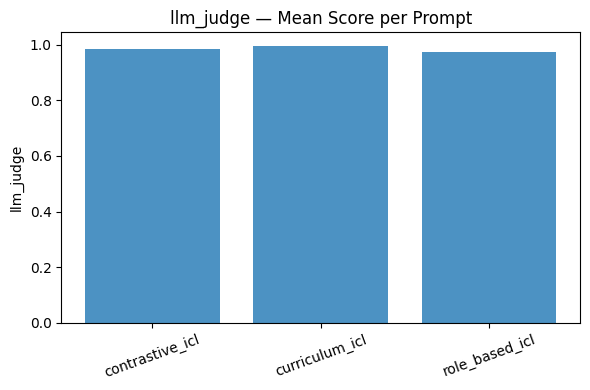

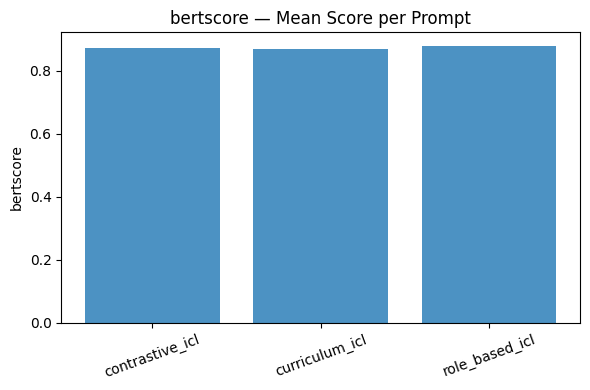

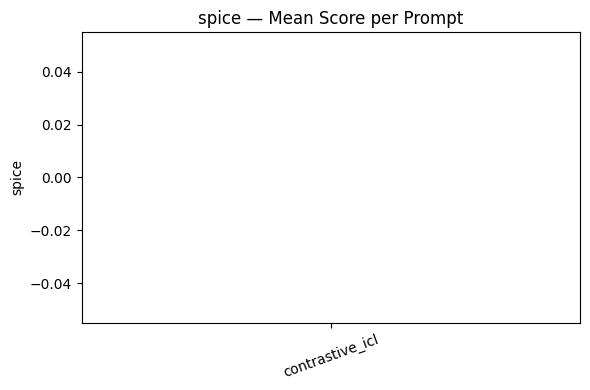

In [ ]:
import matplotlib.pyplot as plt

for metric in long_df["metric"].unique():
    sub = summary_table[summary_table["metric"] == metric]

    plt.figure(figsize=(6,4))
    plt.bar(sub["prompt_type"], sub["mean"], alpha=0.8)
    plt.title(f"{metric} — Mean Score per Prompt")
    plt.ylabel(metric)
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()


In [ ]:
def win_rate(long_df, metric):
    sub = long_df[long_df["metric"] == metric].dropna()

    # pick max per example
    idx = sub.groupby("row_idx")["value"].idxmax()
    winners = sub.loc[idx]

    return winners["prompt_type"].value_counts(normalize=True).round(3)

for metric in long_df["metric"].unique():
    print(f"\n== Win rate for {metric} ==")
    print(win_rate(long_df, metric))



== Win rate for llm_judge ==
prompt_type
curriculum_icl    1.0
Name: proportion, dtype: float64

== Win rate for bertscore ==
prompt_type
contrastive_icl    0.4
role_based_icl     0.4
curriculum_icl     0.2
Name: proportion, dtype: float64

== Win rate for spice ==
Series([], Name: proportion, dtype: float64)


In [ ]:
# Auto-detect metric columns
metric_cols = [
    c for c in df.columns
    if any(m in c.lower() for m in ["llm", "bertscore", "spice"])
]

print("Metric columns:", metric_cols)


Metric columns: ['curriculum_icl_llm_judge', 'curriculum_icl_bertscore', 'curriculum_icl_spice', 'contrastive_icl_llm_judge', 'contrastive_icl_bertscore', 'contrastive_icl_spice', 'role_based_icl_llm_judge', 'role_based_icl_bertscore', 'role_based_icl_spice']


In [ ]:
prompt_summary = (
    df.groupby("prompt_type")[metric_cols]
      .agg(["mean", "std", "median"])
      .round(4)
)

prompt_summary


/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, ou

curriculum_icl_llm_judge                 \
                                    mean     std median   
prompt_type                                               
contrastive_icl                      NaN     NaN    NaN   
curriculum_icl                     0.995  0.0158    1.0   
role_based_icl                       NaN     NaN    NaN   

                curriculum_icl_bertscore                 curriculum_icl_spice  \
                                    mean     std  median                 mean   
prompt_type                                                                     
contrastive_icl                      NaN     NaN     NaN                  NaN   
curriculum_icl                    0.8677  0.0146  0.8657                  NaN   
role_based_icl                       NaN     NaN     NaN                  NaN   

                           contrastive_icl_llm_judge  ...  \
                std median                      mean  ...   
prompt_type                                           ...   
contrastive_icl NaN    NaN                     0.985  ...   
curriculum_icl  NaN    NaN                       NaN  ...   
role_based_icl  NaN    NaN                       NaN  ...   

                contrastive_icl_spice role_based_icl_llm_judge                 \
                               median                     mean     std median   
prompt_type                                                                     
contrastive_icl                   NaN                      NaN     NaN    NaN   
curriculum_icl                    NaN                      NaN     NaN    NaN   
role_based_icl                    NaN                    0.975  0.0264  0.975   

                role_based_icl_bertscore                 role_based_icl_spice  \
                                    mean     std  median                 mean   
prompt_type                                                                     
contrastive_icl                      NaN     NaN     NaN                  NaN   
curriculum_icl                       NaN     NaN     NaN                  NaN   
role_based_icl                     0.878  0.0124  0.8787                  NaN   

                            
                std median  
prompt_type                 
contrastive_icl NaN    NaN  
curriculum_icl  NaN    NaN  
role_based_icl  NaN    NaN  

[3 rows x 27 columns]

## Sanity check


In [ ]:
# Load pre-trained base model
model_base = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
processor_base = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

# Load fine-tuned CameraBench model
model_ft = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "chancharikm/qwen2.5-vl-7b-cam-motion",
    torch_dtype="auto",
    device_map="auto"
)
processor_ft = AutoProcessor.from_pretrained("chancharikm/qwen2.5-vl-7b-cam-motion")

print("Loaded both base + FT models ✓")


NameError: name 'Qwen2_5_VLForConditionalGeneration' is not defined